In [1]:
from scipy.stats import t
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import lambertw
from numpy import unravel_index

In [13]:
# global plot setting
SIZELINE = 1.0
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE*2, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)
DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

# global variables
mu_low, mu_high       = -10, 10          # the range of mu in grid setting
theta_low, theta_high = -10, 10          # the range of theta in grid setting
kappaDs               = [20,50,200,500]  # the choice of kappa_D

## Create dynamic environments, changing true mean/variance

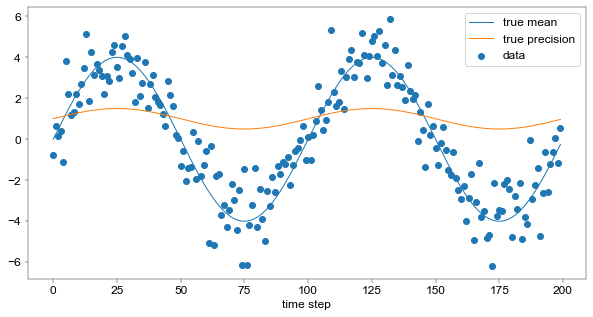

In [3]:
# create true mean(mu), 'variance'(lambda) and signal (xs)
N=200
period = 100
true_mu=[]
true_lambda=[]
true_xs=[]
for i in range(N):
	true_mu.append(4.0*np.sin(2*np.pi*i/period))
	true_lambda.append(0.5*np.sin(2*np.pi*i/period)+1)
	true_xs.append(np.random.normal(true_mu[-1],np.sqrt(1/true_lambda[-1]))) # x~N(mu,1)
# plot true 
fig = plt.subplots(figsize=(10,5))
plt.plot(true_mu,label='true mean')
plt.plot(true_lambda,label='true precision')
plt.scatter(np.arange(N),true_xs,label='data')
plt.xlabel('time step')
plt.legend()
plt.show()

np.savetxt('true_mu.txt',true_mu)
np.savetxt('true_lambda.txt',true_lambda)
np.savetxt('truexs.txt',true_xs) 

## Numerically calculate posterior for all steps

In [4]:
def prior_setting(grid_mus, grid_thetas):
	# Initial p[mu,theta] from peak d=10, mu~N(0,1), theta~N(0, 1)
	len_mus = len(grid_mus)
	len_thetas = len(grid_thetas)
	initial_p = np.zeros((len_mus, len_thetas))
	peak_mu = 0
	peak_theta = 0
	for i in range(len_mus):
		for j in range(len_thetas):
			initial_p[i,j] = np.exp( - (grid_mus[i] - peak_mu)**2 / 2) * np.exp( - (grid_thetas[j] - peak_theta)**2 / 2)
	initial_p_normalized = initial_p / np.sum(initial_p) / dx**2
	np.savetxt('posterior_initial.txt', initial_p_normalized)
	return(initial_p_normalized)

def transition_matrix(sub_d, dx, kappa_D):
	sub_dn = int(sub_d/dx)
	T_matrix = np.zeros((2*sub_dn+1, 2*sub_dn+1))
	for i in range(-sub_dn, sub_dn+1):
		for j in range(-sub_dn, sub_dn+1):
			T_matrix[i+sub_dn,j+sub_dn] = np.exp( -0.5*kappa_D*( (i*dx)**2 + (j*dx)**2 ) )
	return(T_matrix) #/ np.sum(T_matrix)

def update_post(x, past_p_normalized, grid_mus, grid_thetas, sub_d, dx, T_matrix):
	len_mus = len(grid_mus)
	len_thetas = len(grid_thetas)
	sub_dn = sub_d / dx
	p_integ = np.zeros((len_mus, len_thetas))
	for i in range(len_mus):
		for j in range(len_thetas):
			mu_c = grid_mus[i]
			theta_c = grid_thetas[j]
			
			mu_L = int( max(0, i - sub_dn) ) #(mu_low,mu-r) 
			mu_R = int( min(len_mus, i + sub_dn + 1) ) #(mu_high,mu+r)
			theta_L = int( max(0, j - sub_dn) ) #(theta_low,theta-r) 
			theta_R = int( min(len_thetas, j + sub_dn + 1) ) #(theta_high,theta+r)
			
			T_row_L = int( max(0, sub_dn - i) )
			T_row_R = int( min(2*sub_dn + 1, sub_dn + len_mus - i) )
			T_col_L = int( max(0, sub_dn - j) )
			T_col_R = int( min(2*sub_dn + 1, sub_dn + len_thetas - j) )
			
			p_integ[i,j] = np.sum(past_p_normalized[mu_L:mu_R, theta_L:theta_R] * T_matrix[T_row_L:T_row_R, T_col_L:T_col_R])
			p_integ[i,j] = p_integ[i,j]*np.exp(theta_c/2-0.5 * np.exp(theta_c) * (x - mu_c)**2)
	p_posterior = p_integ / np.sum(p_integ) / dx**2
	return(p_posterior)

def main(kappa_D, dx, grid_mus, grid_thetas, true_xs, initial_p_normalized):
	# cal transition matrix
	sub_d = 2 # sub_d >> 1/sqrt(k_D)
	T_matrix = transition_matrix(sub_d, dx, kappa_D)
	# update
	N = len(true_xs)
	data_posterior = pd.DataFrame()
	mu_maxs = np.zeros(N)
	theta_maxs = np.zeros(N)
	past_p_normalized = initial_p_normalized
	for istep in range(N):
		x = true_xs[istep]
		p_posterior = update_post(x, past_p_normalized, grid_mus, grid_thetas, sub_d, dx, T_matrix)
		maxi, maxj = unravel_index(p_posterior.argmax(), p_posterior.shape)
		mu_maxs[istep] = grid_mus[maxi]
		theta_maxs[istep] = grid_thetas[maxj]
		if istep%20 == 0:
			data_posterior['step %d'%istep] = p_posterior.flat
		past_p_normalized = p_posterior
	np.savetxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx), mu_maxs)
	np.savetxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx), theta_maxs)
	data_posterior.to_csv('Posterior_kappaD%d_ny%d-dx%.2f.csv.gz'%(kappa_D, len(grid_thetas), dx), compression='gzip')

true_xs = np.loadtxt('truexs.txt')
for kappa_D in kappaDs:
	for dx in [0.1, 0.05]:
		print(kappa_D, dx)
		grid_mus = np.arange(mu_low,mu_high,dx)
		grid_thetas = np.arange(theta_low, theta_high,dx)
		# initial prior distribution
		initial_p_normalized = prior_setting(grid_mus, grid_thetas)
		main(kappa_D, dx, grid_mus, grid_thetas, true_xs, initial_p_normalized) 

20 0.1
20 0.05
50 0.1
50 0.05
200 0.1
200 0.05
500 0.1
500 0.05


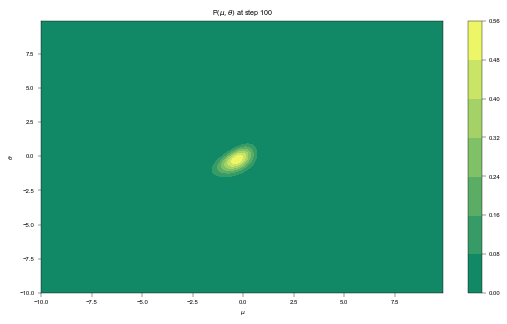

In [17]:
# plotting the posterior distributoin
def plot_posterior_step(kappa_D, dx, leny, istep):
	fig,axs = plt.subplots(figsize=(9,5))
	axs.set_xlabel(r'$\mu$')
	axs.set_ylabel(r'$\theta$')
	cmap = plt.cm.get_cmap("summer")
	X, Y = np.meshgrid(grid_mus, grid_thetas)
	data = pd.read_csv('Posterior_kappaD%d_ny%d-dx%.2f.csv'%(kappa_D, leny, dx),index_col=0)
	cols = data.columns
	idata = data[cols[istep]].values
	idata = np.array(idata).reshape((-1,len(grid_thetas)))
	contourf1 = axs.contourf(X, Y, idata.T, cmap = cmap)
	axs.set_title(r'P($\mu,\theta$) at step %d'%istep)
	fig.colorbar(contourf1, ax=axs)
	plt.show()
kappa_D = 20
dx = 0.1
grid_mus = np.arange(mu_low,mu_high,dx)
grid_thetas = np.arange(theta_low, theta_high,dx)
leny = len(grid_thetas)
plot_posterior_step(kappa_D, dx, leny, istep = 100)

## dx choosing for convergence, dx=0.1 is good

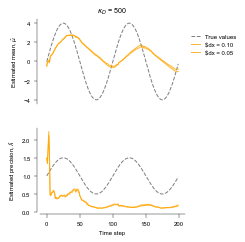

In [18]:
# prove the convergence of dx choosing
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.17, 0.6, 0.6, 0.35])
ax2 = fig.add_axes([0.17, 0.15, 0.6, 0.35])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, labelbottom=False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))

ax2.set_xlabel('Time step')
ax1.set_ylabel('Estimated mean, $\hat{\mu}$')
ax2.set_ylabel('Estimated precision, $\hat{\lambda}$')

true_mu = np.loadtxt('true_mu.txt')
true_lambda = np.loadtxt('true_lambda.txt')

ax1.plot(true_mu,label='True values', **DASH_STYLE)
ax2.plot(true_lambda, **DASH_STYLE)

alphas = [0.4, 0.8, 0.4, 0.8]
colors = ['green', 'green', 'orange', 'orange']
dxs = [0.1, 0.05]
kappa_D = 500
mumax = np.loadtxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dxs[0]))
thetamax = np.loadtxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dxs[0]))
lambdamax = np.exp(thetamax)
N = len(mumax)
ax1.plot(np.arange(N), mumax, label='$dx = %.2f'%dxs[0], color=colors[i], alpha=alphas[i])
ax2.plot(np.arange(N), lambdamax, color=colors[i], alpha=alphas[i])

mumax = np.loadtxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dxs[1]))
thetamax = np.loadtxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dxs[1]))
lambdamax = np.exp(thetamax)
N = len(mumax)
ax1.plot(np.arange(N), mumax, label='$dx = %.2f'%dxs[1], color=colors[i], alpha=alphas[i])
ax2.plot(np.arange(N), lambdamax, color=colors[i], alpha=alphas[i])
ax1.set_title('$\kappa_D$ = %d'%kappa_D)

ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.45, 0.1, 0.5),handlelength=1.5, frameon=False)

plt.savefig('dx_compare_kappaD%d.pdf'%kappa_D,format='pdf',dpi=300)
plt.show()

## The maximum point of the distribution is a good estimation of true values

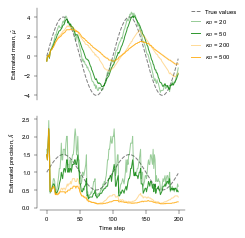

In [19]:
# plot the max values of distibution vs the true distirbution
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.17, 0.6, 0.6, 0.38])
ax2 = fig.add_axes([0.17, 0.15, 0.6, 0.38])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, labelbottom=False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))

ax2.set_xlabel('Time step')
ax1.set_ylabel('Estimated mean, $\hat{\mu}$')
ax2.set_ylabel('Estimated precision, $\hat{\lambda}$')

true_mu = np.loadtxt('true_mu.txt')
true_lambda = np.loadtxt('true_lambda.txt')

ax1.plot(true_mu,label='True values', **DASH_STYLE)
ax2.plot(true_lambda, **DASH_STYLE)

dx = 0.1
alphas = [0.4, 0.8, 0.4, 0.8]
colors = ['green', 'green', 'orange', 'orange']
for i in range(len(kappaDs)):
	kappa_D = kappaDs[i]
	mumax = np.loadtxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	thetamax = np.loadtxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	lambdamax = np.exp(thetamax)
	N = len(mumax)
	ax1.plot(np.arange(N), mumax, label='$\kappa_{D}$ = %d'%kappa_D, color=colors[i], alpha=alphas[i])
	ax2.plot(np.arange(N), lambdamax, color=colors[i], alpha=alphas[i])

ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.45, 0.1, 0.5),handlelength=1.5, frameon=False)

plt.savefig('figs11-numerical_posterior_DBN.pdf',format='pdf',dpi=300)
plt.show()

## Comparing DBN with our model result and approximation Q

In [24]:
# functions used by multiple cells
def setSubFigTicks(ax, position):
	if position == 'left':
		ax.spines['right'].set_visible(False)
		ax.spines['top'].set_visible(False)
		ax.spines['bottom'].set_visible(False)
		ax.spines['left'].set_position(('axes', -0.02))
		ax.tick_params(bottom=False, labelbottom=False)
		ax.set_ylabel('Estimated mean, $\hat{\mu}$')
		ax.set_xlim(0,200)
		ax.set_ylim(-6,6)
	elif position == 'center':
		ax.spines['right'].set_visible(False)
		ax.spines['top'].set_visible(False)
		ax.spines['bottom'].set_visible(False)
		ax.spines['left'].set_visible(False)
		ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
		ax.set_xlim(0,200)
		ax.set_ylim(-6,6)
	elif position == 'bottom':
		ax.spines['right'].set_visible(False)
		ax.spines['top'].set_visible(False)
		ax.spines['left'].set_visible(False)
		ax.tick_params(left=False, labelleft=False)
		ax.spines['bottom'].set_position(('axes', -0.02))
		ax.set_xlabel('Time step')
		ax.set_xlim(0,200)
		ax.set_ylim(0,6)
	elif position == 'corner':
		ax.spines['right'].set_visible(False)
		ax.spines['top'].set_visible(False)
		ax.spines['bottom'].set_position(('axes', -0.02))
		ax.spines['left'].set_position(('axes', -0.02))
		ax.set_xlabel('Time step')
		ax.set_ylabel('Estimated precision, $\hat{\lambda}$')
		ax.set_xlim(0,200)
		ax.set_ylim(0,6)
	return(ax)
def cal_parametrs(kappa_D, true_xs):  # abcd stands for...
	mu_mus = np.ones(N) # mu ~ N(mu_mu,1/lambda_mu) 
	lambda_mus = np.ones(N)
	mu_thetas = np.ones(N) # theta ~ N(mu_theta,1/e^lambda_theta)
	lambda_thetas = np.ones(N)
	mu_mu_past = 0
	lambda_mu_past = 1
	mu_theta_past = 0
	lambda_theta_past = 1
	for i in range(N):
		# inital assume mu_theta = mu_theta_past, ...
		c_mut = kappa_D*lambda_mu_past/(kappa_D+lambda_mu_past)
		c_thetat = kappa_D*lambda_theta_past/(kappa_D+lambda_theta_past)
		E_theta = np.exp( mu_theta_past + 1/2/lambda_theta_past) 
		lambda_mu = E_theta+c_mut
		mu_mu = (E_theta*true_xs[i]+c_mut*mu_mu_past)/lambda_mu
		E_mu = (true_xs[i]-mu_mu)**2+1/lambda_mu
		lambda_theta = c_thetat + E_mu/2*E_theta
		mu_theta = mu_theta_past+1/2/c_thetat - lambertw(E_mu/2/c_thetat*np.exp(mu_theta_past+1/2/c_thetat)).real
		presumerror = 100000 # a large value 
		sumerror = sum([abs(lambda_mu),abs(mu_mu),abs(mu_theta),abs(lambda_theta)])
		j=0
		while abs(sumerror-presumerror) > 0.01:
			j+=1
			if j==200:
				print(kappa_D,i)
				break
			presumerror = sumerror
			E_theta = np.exp( mu_theta + 1/2/lambda_theta) 
			lambda_mu = E_theta+c_mut
			mu_mu = (E_theta*true_xs[i]+c_mut*mu_mu_past)/lambda_mu
			E_mu = (true_xs[i]-mu_mu)**2+1/lambda_mu
			lambda_theta = c_thetat + E_mu/2*E_theta
			mu_theta = mu_theta_past+1/2/c_thetat - lambertw(E_mu/2/c_thetat*np.exp(mu_theta_past+1/2/c_thetat)).real
			sumerror = sum([abs(lambda_mu),abs(mu_mu),abs(mu_theta),abs(lambda_theta)])
		lambda_mus[i] = lambda_mu
		mu_mus[i]     = mu_mu
		lambda_thetas[i] = lambda_theta
		mu_thetas[i]     = mu_theta
		mu_mu_past = mu_mu
		lambda_mu_past = lambda_mu
		mu_theta_past = mu_theta
		lambda_theta_past = lambda_theta
	return(mu_mus,lambda_mus, mu_thetas, lambda_thetas)

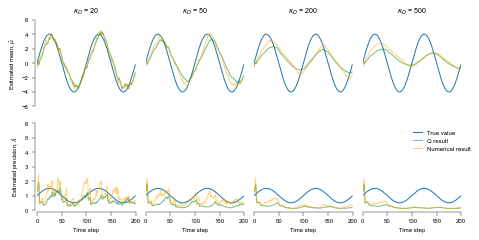

In [25]:
# plot the approximation Q vs numerical result
def plotkappa_D(ax1, ax2, kappa_D=20):
	truexs = np.loadtxt('truexs.txt')
	true_mu = np.loadtxt('true_mu.txt')
	true_lambda = np.loadtxt('true_lambda.txt')
	ax1.plot(true_mu,label='True value')
	ax2.plot(true_lambda,label='True value')
	ax1.set_title(r'$\kappa_{D}$ = %.0f'%kappa_D)
	# data
	mu_mus,lambda_mus, mu_thetas, lambda_thetas = cal_parametrs(kappa_D, truexs)
	ax1.plot(mu_mus, label='Q result', alpha=0.5, color = 'green')
	ax2.plot(np.exp(mu_thetas), label='Q result', alpha=0.5, color = 'green')
	
	dx = 0.1
	mumax = np.loadtxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	thetamax = np.loadtxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	lambdamax = np.exp(thetamax)
	ax1.plot(mumax, label='Numerical result' , alpha=0.5, color = 'orange')
	ax2.plot(lambdamax, label='Numerical result' , alpha=0.5, color = 'orange')
	return(ax1, ax2)


fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax11 = fig.add_axes([0.1, 0.55, 0.2, 0.36])
ax12 = fig.add_axes([0.32, 0.55, 0.2, 0.36])
ax13 = fig.add_axes([0.54, 0.55, 0.2, 0.36])
ax14 = fig.add_axes([0.76, 0.55, 0.2, 0.36])

ax21 = fig.add_axes([0.1, 0.12, 0.2, 0.36])
ax22 = fig.add_axes([0.32, 0.12, 0.2, 0.36])
ax23 = fig.add_axes([0.54, 0.12, 0.2, 0.36])
ax24 = fig.add_axes([0.76, 0.12, 0.2, 0.36])

ax11 = setSubFigTicks(ax11, 'left')
ax12 = setSubFigTicks(ax12, 'center')
ax13 = setSubFigTicks(ax13, 'center')
ax14 = setSubFigTicks(ax14, 'center')
ax21 = setSubFigTicks(ax21, 'corner')
ax22 = setSubFigTicks(ax22, 'bottom')
ax23 = setSubFigTicks(ax23, 'bottom')
ax24 = setSubFigTicks(ax24, 'bottom')

ax11, ax21 = plotkappa_D(ax11,ax21, kappa_D=20)
ax12, ax22 = plotkappa_D(ax12,ax22, kappa_D=50)
ax13, ax23 = plotkappa_D(ax13,ax23, kappa_D=200)
ax14, ax24 = plotkappa_D(ax14,ax24, kappa_D=500)
ax24.legend(loc='center',bbox_to_anchor=(0.75, 0.55, 0.1, 0.5),handlelength=1.5, frameon=False)


plt.savefig('Qvsnumallkappa.pdf')
plt.show()

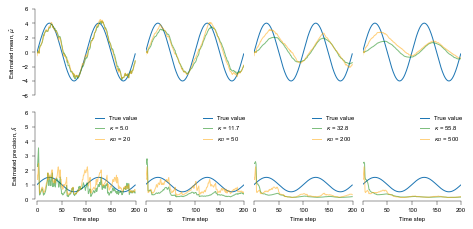

In [26]:
# find equivalant kappa
def cal_m(kappa,true_xs):
	# calculate evalution of m under the signals generateed
	alpha = kappa/2
	m_past = 0
	var_past = 0.4
	ms = []
	lambdas = []
	for i in range(N):
		m_new = (kappa*m_past+true_xs[i])/(kappa+1)
		var_new = (alpha-1)/(alpha-0.5)*var_past + 0.5/(alpha-0.5)*kappa/(kappa+1)*(true_xs[i]-m_past)**2
		ms.append(m_new)
		lambdas.append(1/var_new)
		m_past = m_new
		var_past = var_new
	return(ms,lambdas)

def cal_kappa_equiv(kappa_D, true_xs):
	mu_mus,lambda_mus, mu_thetas, lambda_thetas = cal_parametrs(kappa_D, true_xs)
	array_lambda_mus = np.array(lambda_mus)
	array_mu_thetas = np.array(mu_thetas)
	array_lambda_thetas = np.array(lambda_thetas)
	array_Etheta = np.exp(array_mu_thetas +0.5/array_lambda_thetas)
	inverse_kappa = array_Etheta/kappa_D+array_Etheta/array_lambda_mus
	array_kappa = 1/inverse_kappa
	return(np.mean(array_kappa))

def plotkappakappaD(ax1, ax2, kappa_D):
	true_xs = np.loadtxt('truexs.txt')
	true_mu = np.loadtxt('true_mu.txt')
	true_lambda = np.loadtxt('true_lambda.txt')
	ax1.plot(true_mu,label='True value')
	ax2.plot(true_lambda,label='True value')

	dx = 0.1
	mumax = np.loadtxt('estimated-mu-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	thetamax = np.loadtxt('estimated-theta-max-kappaD%d-dx%.2f.txt'%(kappa_D, dx))
	lambdamax = np.exp(thetamax)
	
	kappa = cal_kappa_equiv(kappa_D, true_xs)
	ms, lambdas = cal_m(kappa,true_xs)
	ax1.plot(ms, label=r'$\kappa$ = %.1f'%kappa , alpha=0.5, color = 'green')
	ax2.plot(lambdas, label=r'$\kappa$ = %.1f'%kappa , alpha=0.5, color = 'green')

	ax1.plot(mumax, label=r'$\kappa_{D}$ = %d'%kappa_D  , alpha=0.5, color = 'orange')
	ax2.plot(lambdamax, label=r'$\kappa_{D}$ = %d'%kappa_D   , alpha=0.5, color = 'orange')

	ax2.legend(loc='center',bbox_to_anchor=(0.75, 0.55, 0.1, 0.5),handlelength=1.5, frameon=False)
	return(ax1,ax2)

fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax11 = fig.add_axes([0.1, 0.55, 0.2, 0.36])
ax12 = fig.add_axes([0.32, 0.55, 0.2, 0.36])
ax13 = fig.add_axes([0.54, 0.55, 0.2, 0.36])
ax14 = fig.add_axes([0.76, 0.55, 0.2, 0.36])

ax21 = fig.add_axes([0.1, 0.12, 0.2, 0.36])
ax22 = fig.add_axes([0.32, 0.12, 0.2, 0.36])
ax23 = fig.add_axes([0.54, 0.12, 0.2, 0.36])
ax24 = fig.add_axes([0.76, 0.12, 0.2, 0.36])

ax11 = setSubFigTicks(ax11, 'left')
ax12 = setSubFigTicks(ax12, 'center')
ax13 = setSubFigTicks(ax13, 'center')
ax14 = setSubFigTicks(ax14, 'center')
ax21 = setSubFigTicks(ax21, 'corner')
ax22 = setSubFigTicks(ax22, 'bottom')
ax23 = setSubFigTicks(ax23, 'bottom')
ax24 = setSubFigTicks(ax24, 'bottom')

ax11, ax21 = plotkappakappaD(ax11,ax21, kappa_D=20)
ax12, ax22 = plotkappakappaD(ax12,ax22, kappa_D=50)
ax13, ax23 = plotkappakappaD(ax13,ax23, kappa_D=200)
ax14, ax24 = plotkappakappaD(ax14,ax24, kappa_D=500)


plt.savefig('figs12-dbnvsexp.pdf')
plt.show()